## Functions to calculate streamflow metrics

In [84]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker
from importlib import reload
from dataretrieval import nwis
from datetime import timedelta

import os
import warnings
import calendar
#import pymannkendall as mk

from datetime import datetime

In [158]:
# Variables
site_id = '11447650'
DEFAULT_START = '1900-10-01'
DEFAULT_END = '2014-09-30'
data_range = 30
MAX_MISSING_THRESHOLD = 0.10
quantile = 0.9
SEC_PER_DAY = 86400
HYDRO_YEAR = 'AS-OCT'
CUBIC_FT_KM_FACTOR = 0.0000000000283168466

In [159]:
# Download streamflow data
def download_usgs_data(site_id, start_date, end_date):
    df = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').rename(columns={'00060_Mean': 'flow_cfs'})
    #df = nwis.get_record(sites=str(site_id), service='dv', start=start_date, end=end_date, parameterCd='00060').drop(columns=['00060_Mean_cd', 'site_no']).rename(columns={'00060_Mean': 'flow_cfs'})
    return df

df = download_usgs_data(site_id, DEFAULT_START, DEFAULT_END)
df

,flow_cfs,00060_Mean_cd,site_no
datetime,,,
1948-10-01 00:00:00+00:00,10400.0,A,11447650
1948-10-02 00:00:00+00:00,10300.0,A,11447650
1948-10-03 00:00:00+00:00,10300.0,A,11447650
1948-10-04 00:00:00+00:00,10200.0,A,11447650
1948-10-05 00:00:00+00:00,9900.0,A,11447650
...,...,...,...
2014-09-26 00:00:00+00:00,7560.0,A,11447650
2014-09-27 00:00:00+00:00,7780.0,A,11447650
2014-09-28 00:00:00+00:00,7740.0,A,11447650


In [160]:
df_valid = df.reset_index()

# "start" is 30 years (or other data range) before the default end date (not the last date of the df)
start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
print(start)

# Restrict df to all dates after the theorectical start date
#df_valid = df_valid[df_valid['datetime'].dt.date >= start]
#print(df_valid)

# Create a new column where each date present equals 1
df_valid['00060_Mean'] = 1 
print(df_valid)

1984-09-30
                       datetime  flow_cfs 00060_Mean_cd   site_no  00060_Mean
0     1948-10-01 00:00:00+00:00   10400.0             A  11447650           1
1     1948-10-02 00:00:00+00:00   10300.0             A  11447650           1
2     1948-10-03 00:00:00+00:00   10300.0             A  11447650           1
3     1948-10-04 00:00:00+00:00   10200.0             A  11447650           1
4     1948-10-05 00:00:00+00:00    9900.0             A  11447650           1
...                         ...       ...           ...       ...         ...
24101 2014-09-26 00:00:00+00:00    7560.0             A  11447650           1
24102 2014-09-27 00:00:00+00:00    7780.0             A  11447650           1
24103 2014-09-28 00:00:00+00:00    7740.0             A  11447650           1
24104 2014-09-29 00:00:00+00:00    7210.0             A  11447650           1
24105 2014-09-30 00:00:00+00:00    7370.0             A  11447650           1

[24106 rows x 5 columns]


## Validation (missing less than 10% of dates over date range)

Start of 30-year record: 1984-09-30
Start of gage record: 1984-09-30 00:00:00+00:00
End of gage record: 2014-09-30 00:00:00+00:00
Valid: True -- Missing -0.0091%


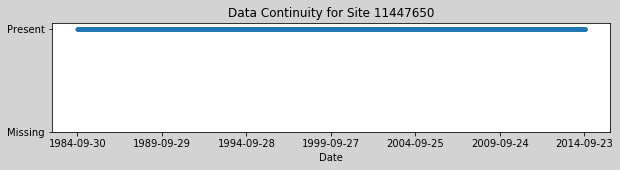

In [161]:
def validate(df: pd.DataFrame, start: datetime, end: datetime):
    """Returns the % amount of data missing from the analyzed range"""
    t_delta = pd.to_datetime(end) - pd.to_datetime(start)
    days = t_delta.days
    missing = 1.0 - (len(df) / days)   # len of df is record of usgs gauge and days is number of days in past 30 years        
    return missing

# Reset the index to numbers (not dates)
df_valid = df.reset_index()

# "start" is 30 years (or other data range) before the default end date (not the last date of the df)
start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
print(f'Start of 30-year record: {start}')

# Restrict df to all dates after the theorectical start date
df_valid = df_valid[df_valid['datetime'].dt.date >= start]
start_df = df_valid['datetime'].iloc[0]
end_df = df_valid['datetime'].iloc[-1]
print(f'Start of gage record: {start_df}')
print(f'End of gage record: {end_df}')

# Create a new column where each date present equals 1
df_valid['00060_Mean'] = 1 

missing = validate(df_valid, start, DEFAULT_END)
print(f"Valid: {missing < MAX_MISSING_THRESHOLD} -- Missing {missing * 100:.4f}%")

# Create missing dates and set their values to 0
complete_range = pd.date_range(start=start, end=DEFAULT_END, freq='D') # daily dates for selected record length (e.g., 30 years)
df_complete = pd.DataFrame({'datetime': complete_range})
df_valid = pd.concat([df_complete.set_index('datetime').tz_localize(None), df_valid.set_index('datetime').tz_localize(None)], axis=1, join='outer').fillna(0).reset_index()

plt.figure(figsize=(10, 2), facecolor='lightgray')
plt.plot(df_valid['datetime'], df_valid['00060_Mean'], marker='.', linestyle='dotted')

plt.yticks([0, 1], ['Missing', 'Present'])
plt.xticks(df_valid['datetime'][::(365*5)]) # syntax: start:stop:step (step of 5 years)
plt.xlabel("Date")

plt.title(f"Data Continuity for Site {site_id}")
plt.show()

## Data: Threshold

Threshold: 52350.0 cfs


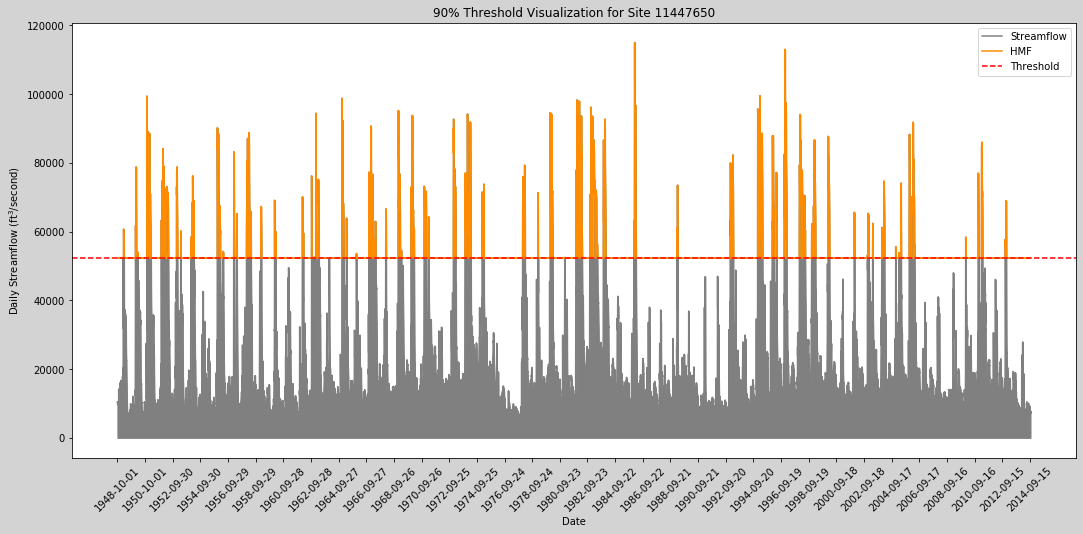

In [162]:
def calc_threshold(df: pd.DataFrame, value: float):
    """Returns a threshold above which flow is considered HMF given flow values and a threshold 0 < t < 1""" 
    df = pd.DataFrame(df['flow_cfs'])
    return df.quantile(q=value, axis=0).iloc[0]

df = download_usgs_data(site_id, DEFAULT_START, DEFAULT_END)
df_threshold = df.reset_index()

#start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]

# Add this line of code for plotting (set index as 'datetime', remove timezone which can cause issues, reset index)
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()

#print(df_threshold)
      
threshold = calc_threshold(df_threshold, quantile)
print(f"Threshold: {threshold} cfs")

df_threshold["diff"] = df_threshold['flow_cfs'] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x)) + threshold
#print(df_threshold)


plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold['datetime'], df_threshold['flow_cfs'], label="Streamflow", color="gray")
plt.plot(df_threshold['datetime'], df_threshold["hmf"], label="HMF", color="darkorange")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.fill_between(df_threshold["datetime"], df_threshold["flow_cfs"], color="gray")
plt.fill_between(df_threshold["datetime"], y1=threshold, y2=df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily Streamflow ($\mathregular{ft^3}$/second)')

plt.title(f"{quantile*100:.0f}% Threshold Visualization for Site {site_id}")
plt.legend()
plt.show()

## Metric: Magnitude

C:\Users\kondr\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\kondr\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\kondr\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Average Annual HMF: 2.11 km^3/year


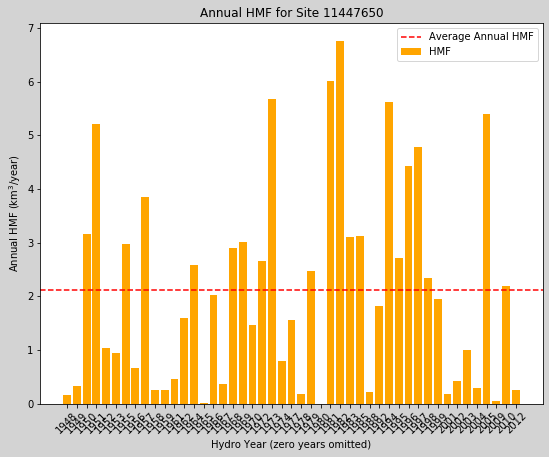

In [229]:
def filter_hmf(df: pd.DataFrame, threshold: float):
    """Returns a dataframe with only flow values above a given threshold present, and a second with non-HMF years zero deflated"""
    zero_defalted_hmf = df.copy()
    hmf_series = df[df['flow_cfs'] > threshold]    
    zero_defalted_hmf['flow_cfs'] = zero_defalted_hmf['flow_cfs'].apply(lambda x: x if x >= threshold else 0) 
    return hmf_series, zero_defalted_hmf

def convert_hmf(df: pd.DataFrame, threshold: float):
    """Converts flow values from ft^3/s to ft^3/day and returns the difference in flow above the threshold"""
    df['flow_cfd'] = (df['flow_cfs'] - threshold) * SEC_PER_DAY
    return df

def num_hmf_years(df: pd.DataFrame, offset: int):
    """Returns the integer number of HMF years, using an offset to indicate the start of the Hydrologic Year (i.e. 10 = October)"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)    
    df.loc[:, 'offsetdate'] = (df.index - pd.offsets.YearBegin(month=offset))    
    return df['offsetdate'].dt.year.nunique()

df_annualhmf = df.reset_index()

#start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_annualhmf = df_annualhmf[df_annualhmf['datetime'].dt.date >= start]

threshold = calc_threshold(df_annualhmf, quantile)
hmf_series, _ = filter_hmf(df_annualhmf, threshold)

hmf_years = num_hmf_years(hmf_series, 10)
hmf_series = convert_hmf(hmf_series, threshold)

hmf_series = hmf_series.reset_index()
hmf_series['datetime'] = pd.to_datetime(hmf_series['datetime'])
hmf_series.set_index('datetime', inplace=True)

annual_sum = hmf_series['flow_cfd'].resample(HYDRO_YEAR).sum()
annual_sum = annual_sum * CUBIC_FT_KM_FACTOR
#print(annual_sum)
annual_hmf = annual_sum.sum() / hmf_years
#print(f"Average Annual HMF: {annual_hmf:.2f} km^3/year")
annual_sum_nozero = annual_sum[annual_sum != 0]
#print(annual_sum_nozero)
annual_hmf_nozero = annual_sum_nozero.sum() / hmf_years
print(f"Average Annual HMF: {annual_hmf_nozero:.2f} km^3/year")

# Filtering out 0 years since average is calculated using only non-zero years
# and this will make the visualization more accurate
annual_sum = annual_sum[annual_sum > 0]

fig = plt.figure(figsize=(9, 7), facecolor='lightgray')
plt.bar(range(len(annual_sum.index)), annual_sum, color='orange')
plt.axhline(y=annual_hmf, color='r', linestyle='--')

plt.xlabel('Hydro Year (zero years omitted)')
plt.xticks(range(len(annual_sum.index)), annual_sum.index.strftime('%Y'), rotation=45)
plt.ylabel('Annual HMF ($\mathregular{km^3}$/year)')

plt.title(f'Annual HMF for Site {site_id}')
plt.legend(['Average Annual HMF', 'HMF'])
plt.show()

## Metric: Duration

In [230]:
def calc_duration(df: pd.DataFrame):
    """Returns the total number of HMF days over the dataframes time period"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)  
    df_results = df.resample(HYDRO_YEAR).agg({'flow_cfs': ['count']})
    #print(df_results)
    df_results.columns = ['Count']
    return df_results['Count'].sum() / hmf_years
    #return np.mean(df_results[df_results['Count'] != 0]['Count'])

hmf_series, zero_defalted_hmf = filter_hmf(df_annualhmf, threshold)
#print(hmf_series)
#print(zero_defalted_hmf)
avg_duration = calc_duration(hmf_series)
print(f"Average Annual HMF Duration: {avg_duration:.2f} days/year")

Average Annual HMF Duration: 51.30 days/year


## Metric: Inter-annual frequency

HMF Years: 47
Inter-Annual Frequency:  70.1 %


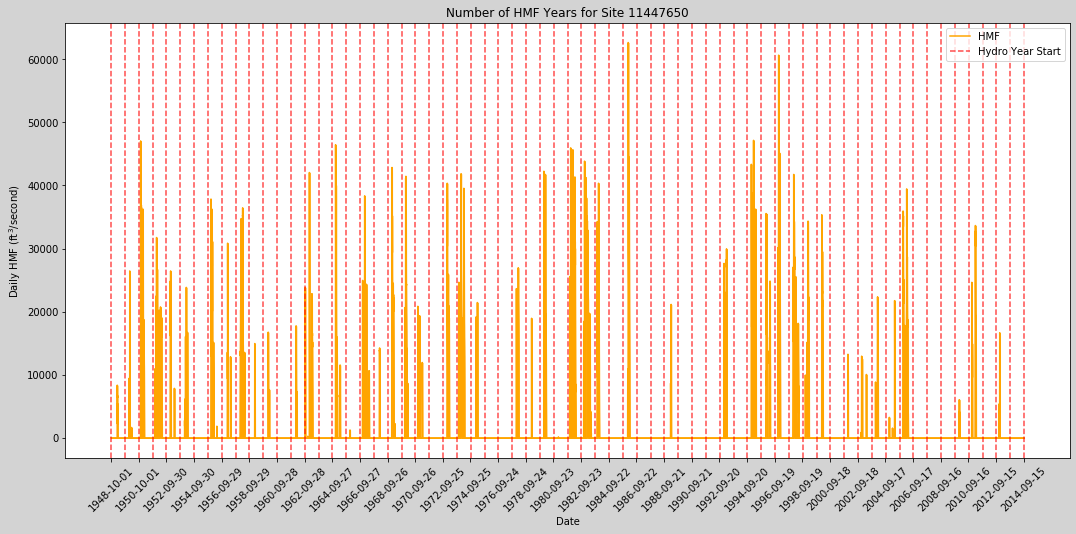

In [231]:
def num_years(df: pd.DataFrame):
    """Returns the integer number of years"""
#     df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
#     df.set_index('datetime', inplace=True)    
#     #df.loc[:, 'offsetdate'] = (df.index - pd.offsets.YearBegin(month=offset))    
#     return df['year'].dt.year.nunique()
    df['year'] = df['datetime'].dt.year
    return df['year'].nunique()

df_threshold = df.reset_index()

#start = pd.to_datetime(DEFAULT_END).date() - timedelta(days=365.25 * data_range)
#df_threshold = df_threshold[df_threshold['datetime'].dt.date >= start]
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()

threshold = calc_threshold(df_threshold, quantile)
hmf_series, _ = filter_hmf(df_threshold, threshold)

hmf_years = num_hmf_years(hmf_series, 10)
print(f"HMF Years: {hmf_years}")

hmf_frequency = hmf_years / num_years(df_threshold) * 100
print(f"Inter-Annual Frequency: {hmf_frequency: 0.1f} %")

df_threshold["diff"] = df_threshold["flow_cfs"] - threshold
df_threshold["hmf"] = df_threshold["diff"].apply(lambda x: max(0, x))

plt.figure(figsize=(18, 8), facecolor='lightgray')
plt.plot(df_threshold["datetime"], df_threshold["hmf"], label="HMF", color="orange")

df_threshold["datetime"] = pd.to_datetime(df_threshold["datetime"], errors='coerce')

first = True
for year in range(df_threshold["datetime"].dt.year.min(), df_threshold["datetime"].dt.year.max() + 1):
    oct1 = pd.to_datetime(f'{year}-10-01')

    if first:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7, label='Hydro Year Start')
        first = False
    else:
        plt.axvline(oct1, color='red', linestyle='--', alpha=0.7)        

plt.fill_between(df_threshold["datetime"], df_threshold["hmf"], color="orange")

plt.xticks(df_threshold['datetime'][::(365*2)], rotation=45)
plt.xlabel("Date")

plt.ylabel('Daily HMF ($\mathregular{ft^3}$/second)')

plt.title(f"Number of HMF Years for Site {site_id}")
plt.legend()
plt.show()

## Metric: Timing

In [232]:
def calc_center_of_mass(df: pd.DataFrame):
    """Calculates the average numerical day per hydrologic year that HMF reaches the center of mass threshold"""
    df = df.reset_index()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['datetime'] = df['datetime'] + pd.DateOffset(months=-9)
    
    # Group data by year
    df['year'] = df['datetime'].dt.year
    df_grouped = df.groupby('year')
    
    # Cumulative sum of the data and halfway point calculation
    df['sum'] = df_grouped['flow_cfs'].cumsum()
    df['half'] = df_grouped['flow_cfs'].transform('sum') / 2
    print(df)
    
    # Filter days up to halfway point and aggregate them
    df = df[df['sum'] >= df['half']]   
    print(df)
    #com_series = df.groupby('year')['datetime'].agg('mean')
    com_series = df_grouped['datetime'].agg('mean')
    
    # Calculate the average day of the hydrologic year that COM occurs    
    # Suppresses obnoxious timezone warning every time this function is called. As far as I can tell we do not care about
    # timezone information in this study, and so dropping tz information will not affect the data
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        start = com_series.dt.to_period('Y').dt.to_timestamp()
        
    com_series = (com_series.dt.tz_localize(None) - start).dt.days
    center_of_mass = sum(com_series) / len(com_series)

    return np.ceil(center_of_mass)

df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_series, _ = filter_hmf(df_threshold, threshold)

center_of_mass = calc_center_of_mass(hmf_series)
center_of_mass

      index   datetime  flow_cfs 00060_Mean_cd   site_no  year       sum  \
0       163 1948-06-13   57800.0             A  11447650  1948   57800.0   
1       164 1948-06-14   60700.0             A  11447650  1948  118500.0   
2       165 1948-06-15   60100.0             A  11447650  1948  178600.0   
3       166 1948-06-16   58800.0             A  11447650  1948  237400.0   
4       167 1948-06-17   59100.0             A  11447650  1948  296500.0   
...     ...        ...       ...           ...       ...   ...       ...   
2406  23462 2012-03-26   69000.0             A  11447650  2012  585100.0   
2407  23463 2012-03-27   67900.0             A  11447650  2012  653000.0   
2408  23464 2012-03-28   66300.0             A  11447650  2012  719300.0   
2409  23465 2012-03-29   62400.0             A  11447650  2012  781700.0   
2410  23466 2012-03-30   57500.0             A  11447650  2012  839200.0   

          half  
0     373150.0  
1     373150.0  
2     373150.0  
3     373150.0  
4 

DataError: No numeric types to aggregate

## Metric: Intra-annual frequency (events per year)

In [258]:
def calc_intra_annual(df: pd.Series, hmf_years: int):
    """Calculates the number of HMF events per hydrological year (consecutive days count as one event)""" 
    df = df.reset_index()   
    # Offsetting dates to make calculations easier (currently HARDCODED)
    date_series = pd.to_datetime(df['datetime'])        
    date_series = date_series + pd.DateOffset(months=-9)
    print(date_series)
    
    df = pd.DataFrame(columns=['Year'])
    
    for i in range(len(date_series)):
        if i == 0:   
            df = pd.concat([df, pd.DataFrame({'Year': date_series.iloc[i].year}, index=[i])], ignore_index=True, axis=0)                          
        else:
            if (date_series.iloc[i] - date_series.iloc[i - 1]).days > 1:
                df = pd.concat([df, pd.DataFrame({'Year': date_series.iloc[i].year}, index=[i])], ignore_index=True, axis=0)
    
    df = df.groupby('Year').size().reset_index(name='hmf_events')
    return df['hmf_events'].sum() / hmf_years

df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_series, _ = filter_hmf(df_threshold, threshold)

intra_annual = calc_intra_annual(hmf_series, hmf_years)
intra_annual

0      1948-06-13
1      1948-06-14
2      1948-06-15
3      1948-06-16
4      1948-06-17
          ...    
2406   2012-03-26
2407   2012-03-27
2408   2012-03-28
2409   2012-03-29
2410   2012-03-30
Name: datetime, Length: 2411, dtype: datetime64[ns]


3.106382978723404

In [262]:
def calc_hmf(df, threshold): # HMF = discharge above threshold
    FlowAbvThresholdList = [(flow - threshold) if flow > threshold else 0 for flow in df['flow_cfs']]
    df['hmf_cfs'] = FlowAbvThresholdList
    return df

def list_of_consec_days_per_event(x): # x is HMF series
    EventDuration = 0
    List_EventDuration = []
    
    # create list that records 0 for 0 HMF days and records number of consecutive HMF days
    for flow in x:
        EventDuration += 1
        if flow == 0:
            EventDuration = 0
        List_EventDuration.append(EventDuration)
    # create new list of the maximum duration of each event (only records a number that is greater than the previous day 
    # and greater than the next day, since the next day should = 0)
    PeakEventDurationList = [List_EventDuration[i] for i in range(len(List_EventDuration)-1) 
                             if (List_EventDuration[i - 1] < List_EventDuration[i]) and (List_EventDuration[i] > List_EventDuration[i + 1])]
    return PeakEventDurationList

def mean_number_of_events(x):
    PeakEventDurationList = list_of_consec_days_per_event(x)
    #print(PeakEventDurationList)
    return len(PeakEventDurationList) # use this for average number of events over some time span

def calc_number_of_events(df):
    df.set_index('datetime', inplace=True)
    AvgNumberofEvents = df['hmf_cfs'].resample('AS-OCT').apply(mean_number_of_events)
    #print(AvgNumberofEvents)
    #timeseries_annual_obs['event_dur_days'][site_id] = AvgEventDuration
    #AvgAnnualEventDuration = AvgEventDuration[AvgEventDuration != 0].dropna().mean()
    #AvgAnnualEventDurationList.append(AvgAnnualEventDuration)
    return AvgNumberofEvents


df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_df = calc_hmf(df_threshold, threshold)

intra_annual = calc_number_of_events(hmf_df)
intra_annual = np.mean(intra_annual[intra_annual != 0])
print(f'Average Annual HMF events: {intra_annual: 0.1f}')

Average Annual HMF events:  2.6


## Metric: Event duration (average duration of individual events per year)

In [265]:
def mean_days_per_event(x):
    PeakEventDurationList = list_of_consec_days_per_event(x)
    return np.mean(PeakEventDurationList) # use this for average number of days per event over some time span

def calc_event_duration(df):
    df.set_index('datetime', inplace=True)
    AvgEventDuration = df['hmf_cfs'].resample('AS-OCT').apply(mean_days_per_event)
    AvgEventDuration = AvgEventDuration.fillna(0)
    #timeseries_annual_obs['event_dur_days'][site_id] = AvgEventDuration
    #AvgAnnualEventDuration = AvgEventDuration[AvgEventDuration != 0].dropna().mean()
    #AvgAnnualEventDurationList.append(AvgAnnualEventDuration)
    return AvgEventDuration

df_threshold = df.reset_index()
df_threshold = df_threshold.set_index('datetime').tz_localize(None).reset_index()
threshold = calc_threshold(df_threshold, quantile)
hmf_df = calc_hmf(df_threshold, threshold)

event_duration = calc_event_duration(hmf_df)
event_duration = np.mean(event_duration[event_duration != 0])
print(f'Average Annual HMF Event Duration: {event_duration: 0.1f} days')

Average Annual HMF Event Duration:  20.0 days
